In [1]:
import torch, scvi, scanpy as sc
print("Torch:", torch.__version__)
print("CUDA disponível:", torch.cuda.is_available())
print("scvi-tools:", scvi.__version__)
print("scanpy:", sc.__version__)


Torch: 2.4.1
CUDA disponível: True
scvi-tools: 1.2.2.post1
scanpy: 1.11.5


/tmp/ipykernel_14924/1978207425.py:5: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("scanpy:", sc.__version__)


In [2]:
import os, scanpy as sc, scvi, torch
sc.settings.verbosity = 3
sc.settings.set_figure_params(figsize=(5,4), dpi=120)
print("Torch:", torch.__version__, "| CUDA:", torch.version.cuda, "| GPU?", torch.cuda.is_available())

DATA_DIR = "../data"
FIG_DIR  = "../figs"
MODEL_DIR = "../models/pbmc3k_scvi"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR,  exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


Torch: 2.4.1 | CUDA: 12.0 | GPU? True


In [3]:
adata = sc.datasets.pbmc3k()  # baixa se não existir no cache
adata.var_names_make_unique()
adata.write_h5ad(f"{DATA_DIR}/pbmc3k_raw.h5ad", compression="lzf")
adata


try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [6]:
import numpy as np
adata = sc.read_h5ad(f"{DATA_DIR}/pbmc3k_raw.h5ad")

adata.var["mt"] = adata.var_names.str.startswith(("MT-","mt-"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)

# filtros razoáveis para PBMC3k
min_genes = 200
max_mt    = 20.0
sc.pp.filter_cells(adata, min_genes=min_genes)
adata = adata[adata.obs["pct_counts_mt"] < max_mt].copy()

# normalização log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVGs + escala
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata, max_value=10)

adata.write_h5ad(f"{DATA_DIR}/pbmc3k_processed.h5ad", compression="lzf")
adata


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 2698 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [5]:
pip install scikit-misc


Note: you may need to restart the kernel to use updated packages.


In [7]:
import scvi, torch, numpy as np
import scanpy as sc

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# garanta que temos uma camada com os "raw counts" para o scvi
# (se você já criou antes, esta linha só sobrescreve igual)
adata.layers["counts"] = adata.X.copy()

# configurações scvi (usa a layer 'counts' e não usa batches)
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

# hiperparâmetros principais
model = scvi.model.SCVI(
    adata,
    n_latent=10,              # dimensão latente
)
model.train(
    max_epochs=200,
    batch_size=1024,
    use_gpu=True,             # True -> usa CUDA (já validado no seu ambiente)
    plan_kwargs={"lr": 1e-3},
)


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scvi/model/_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


TypeError: Trainer.__init__() got an unexpected keyword argument 'use_gpu'

In [8]:
import scanpy as sc

# 1) carrega PBMC3k com contagens brutas
adata = sc.datasets.pbmc3k()

# 2) QC básico
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 3) SALVA contagens brutas antes de qualquer normalização
adata.layers["counts"] = adata.X.copy()

# 4) Normalização/log apenas para estatísticas (não sobrescreve 'counts')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 5) HVGs usando as CONTAGENS (Seurat v3 exige/raw)
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="counts"
)
adata = adata[:, adata.var["highly_variable"]].copy()

# 6) Escala (opcional; não afeta a layer 'counts')
sc.pp.scale(adata, max_value=10)

adata


filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 2700 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [9]:
import scvi
from pathlib import Path

# configura o scVI para usar a layer de contagens brutas
scvi.model.SCVI.setup_anndata(adata, layer="counts")

model = scvi.model.SCVI(adata, n_latent=10)
model.train(
    max_epochs=200,
    batch_size=1024,
    accelerator="gpu",   # ou "auto" se preferir
    devices=1,
    plan_kwargs={"lr": 1e-3},
)

# salvar modelo e adata
out_dir = Path("../results")
(out_dir / "models/scvi_pbmc3k").mkdir(parents=True, exist_ok=True)
(out_dir / "adata").mkdir(parents=True, exist_ok=True)

model.save(out_dir / "models/scvi_pbmc3k", overwrite=True)
adata.write_h5ad(out_dir / "adata/pbmc3k_processed.h5ad", compression="gzip")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [10]:
import matplotlib.pyplot as plt
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(adata)

# clustering opcional
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi")

# figuras
(out_dir / "figures").mkdir(parents=True, exist_ok=True)
sc.pl.umap(adata, color="leiden_scvi", frameon=False, save=None)
plt.savefig(out_dir / "figures/pbmc3k_umap.png", dpi=200, bbox_inches="tight")
plt.show()


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

In [11]:
!conda install -n sc-omics -c conda-forge python-igraph leidenalg -y

/bin/bash: line 1: conda: command not found


In [12]:
!pip install python-igraph leidenalg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 9.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [leidenalg]/4 [igraph]


running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:00)
Figura salva em: ../results/figures/pbmc3k_umap.png


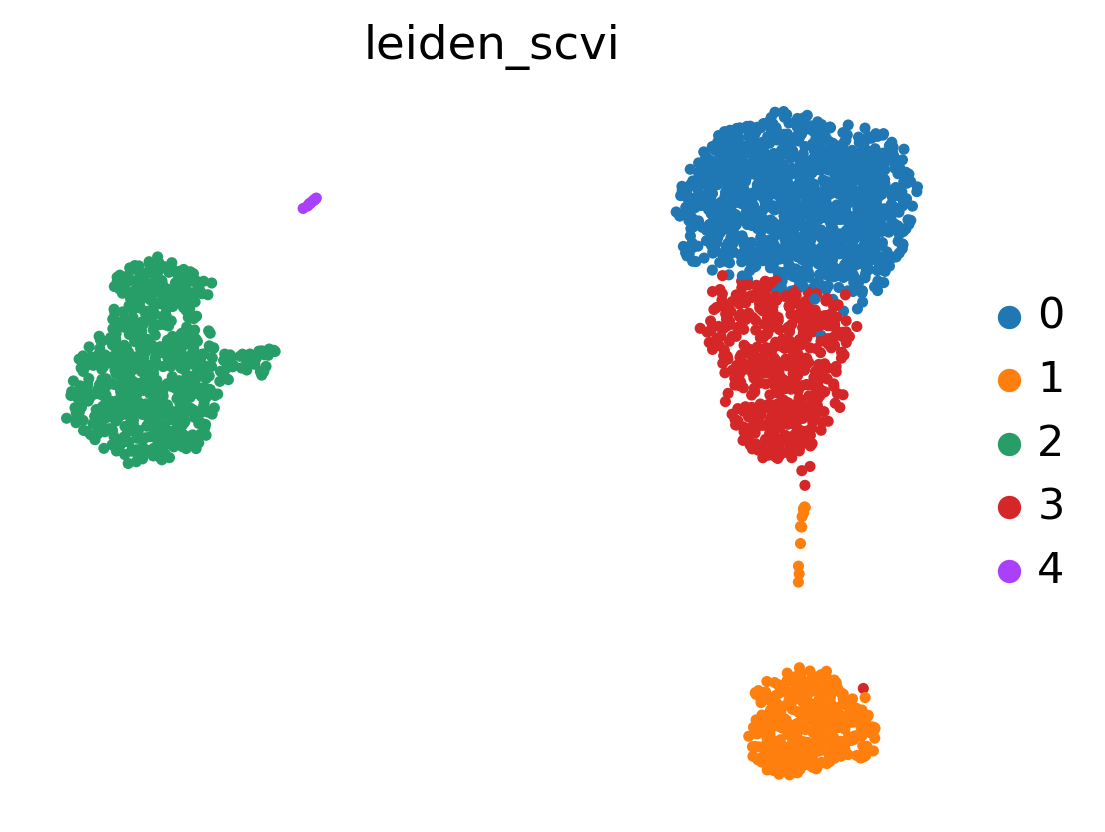

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

# Leiden (usa igraph/leidenalg)
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi", flavor="igraph")

# UMAP colorido por clusters
out_dir = Path("../results")
(out_dir / "figures").mkdir(parents=True, exist_ok=True)

ax = sc.pl.umap(adata, color="leiden_scvi", frameon=False, return_fig=True, show=False)
ax.savefig(out_dir / "figures/pbmc3k_umap.png", dpi=200, bbox_inches="tight")
print("Figura salva em:", out_dir / "figures/pbmc3k_umap.png")


In [14]:
import pandas as pd
pd.DataFrame(adata.obsm["X_scVI"], index=adata.obs_names).to_csv(out_dir / "adata/pbmc3k_X_scVI.csv")
adata.obs[["leiden_scvi"]].to_csv(out_dir / "adata/pbmc3k_leiden.csv")


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value

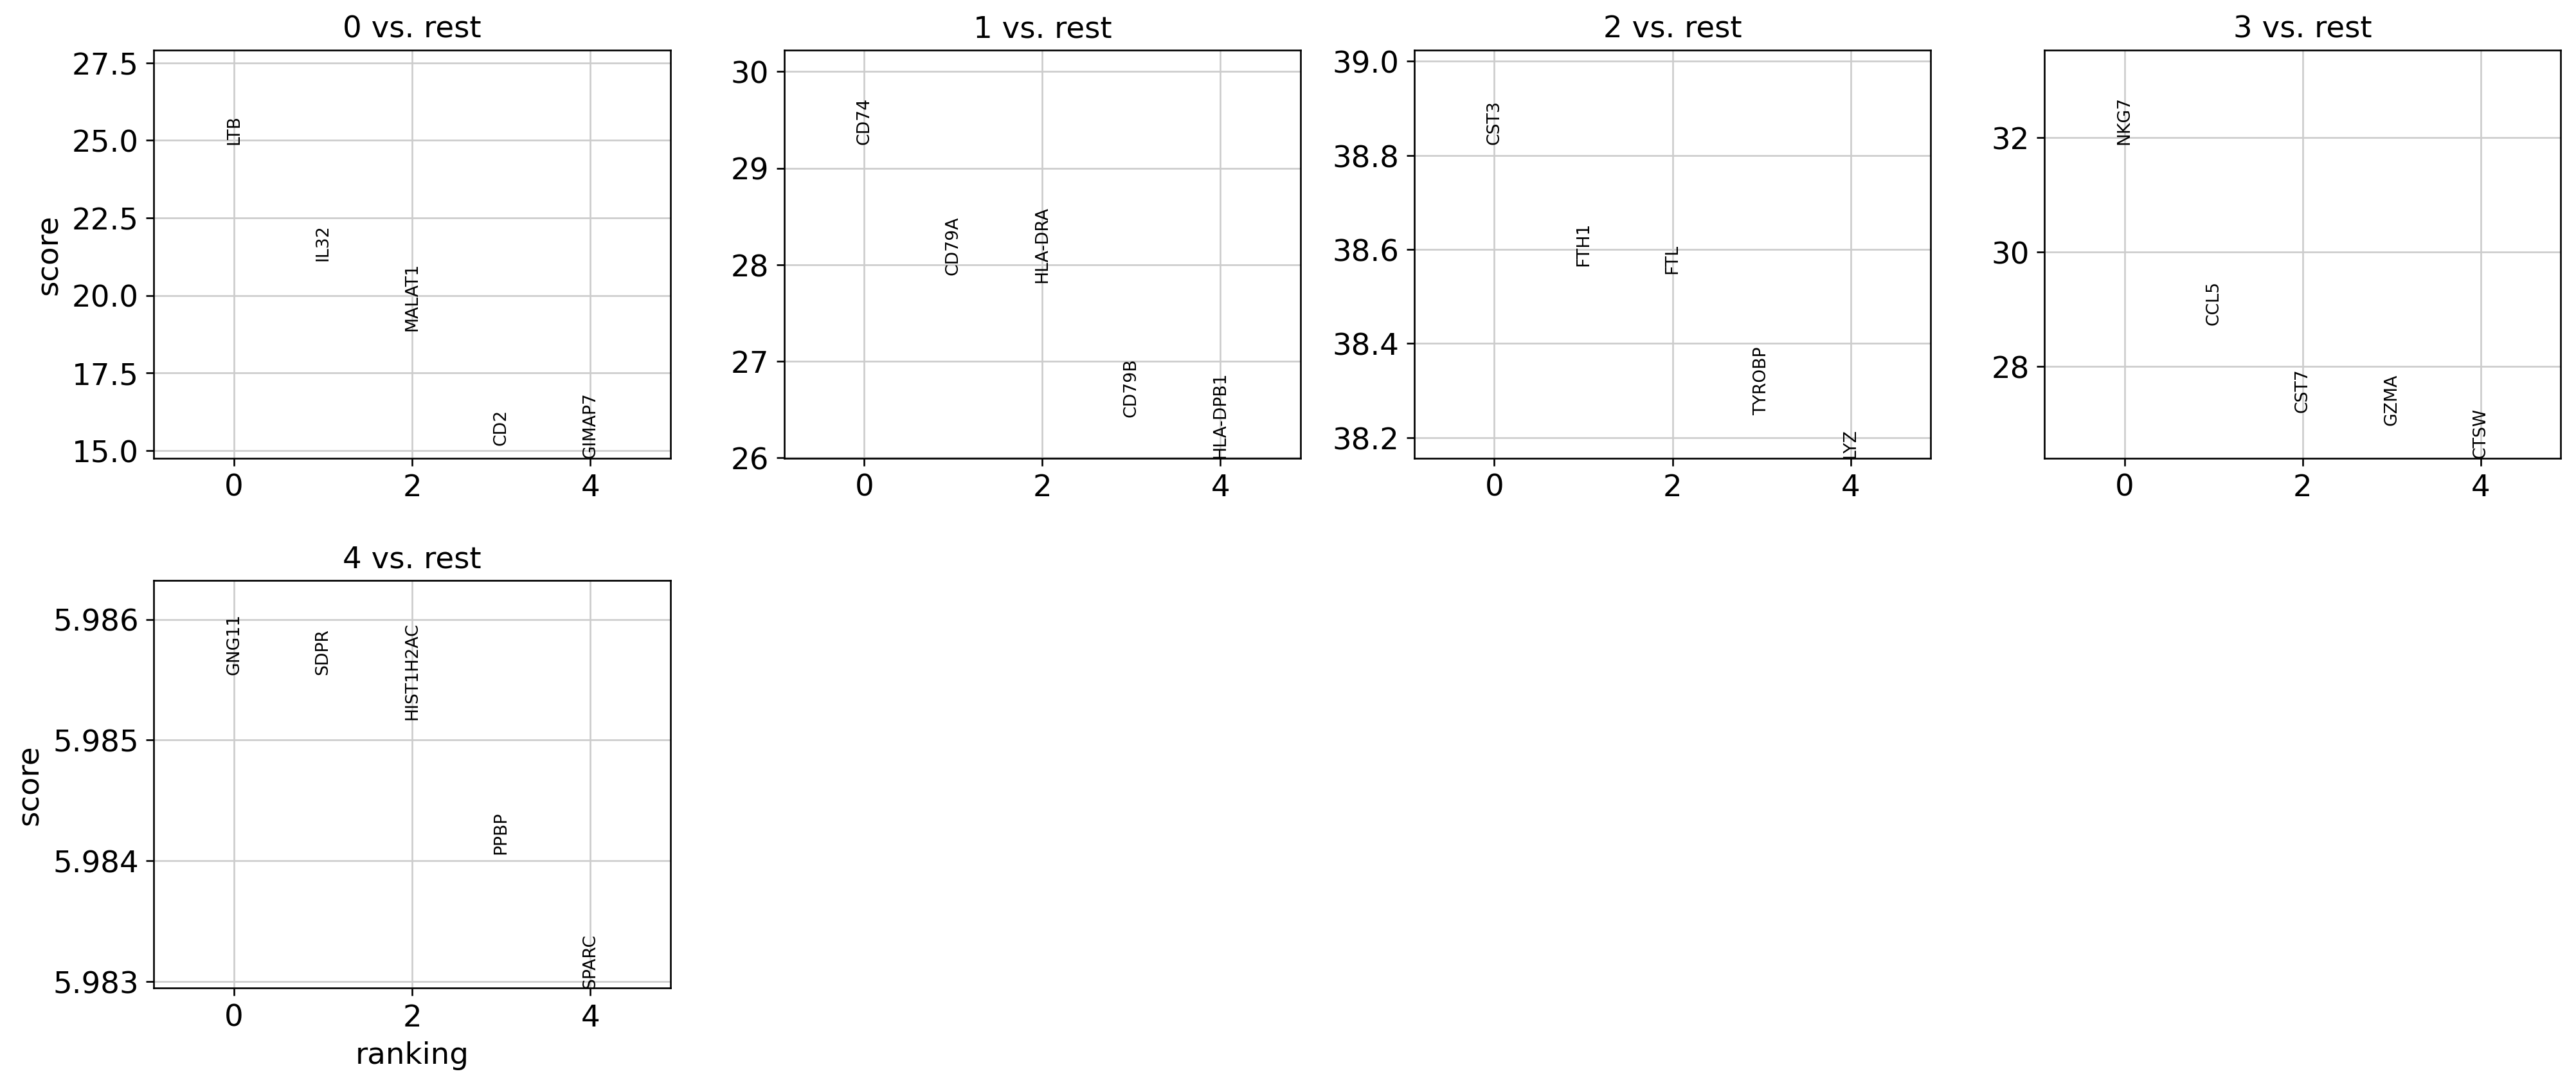

In [15]:
# Calcula genes diferencialmente expressos entre clusters Leiden
sc.tl.rank_genes_groups(adata, groupby="leiden_scvi", method="wilcoxon")

# Visualiza os top genes
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


In [16]:
import scanpy as sc

# 1) Carregue o H5AD cru que usamos lá no começo do pipeline
raw = sc.read_h5ad("../data/raw/pbmc3k_raw.h5ad")

# 2) Garanta a mesma ordem de células do objeto que você clusterizou
raw = raw[adata.obs_names].copy()

# 3) Normaliza + log1p e congela em .raw
sc.pp.normalize_total(raw, target_sum=1e4)
sc.pp.log1p(raw)
raw.raw = raw  # <- daqui pra frente 'use_raw=True' pega esta matriz log-normalizada

# 4) Copie os rótulos dos clusters (Leiden) que você já calculou
raw.obs["leiden_scvi"] = adata.obs["leiden_scvi"].values

# 5) Agora sim: DE em dados corretos (sem escala)
sc.tl.rank_genes_groups(
    raw, groupby="leiden_scvi", method="wilcoxon", use_raw=True
)

# 6) Plots e tabela
sc.pl.rank_genes_groups(raw, n_genes=5, sharey=False)

# exporta CSV com top genes
import pandas as pd
de = sc.get.rank_genes_groups_df(raw, group=None)
de.to_csv("../results/tables/pbmc3k_rank_genes_leiden_scvi.csv", index=False)
print("Salvo em ../results/tables/pbmc3k_rank_genes_leiden_scvi.csv")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/raw/pbmc3k_raw.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

normalizing counts per cell
    finished (0:00:00)
ranking genes


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:391: RuntimeWarning: invalid value encountered in log1p
  np.log1p(x, out=x)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


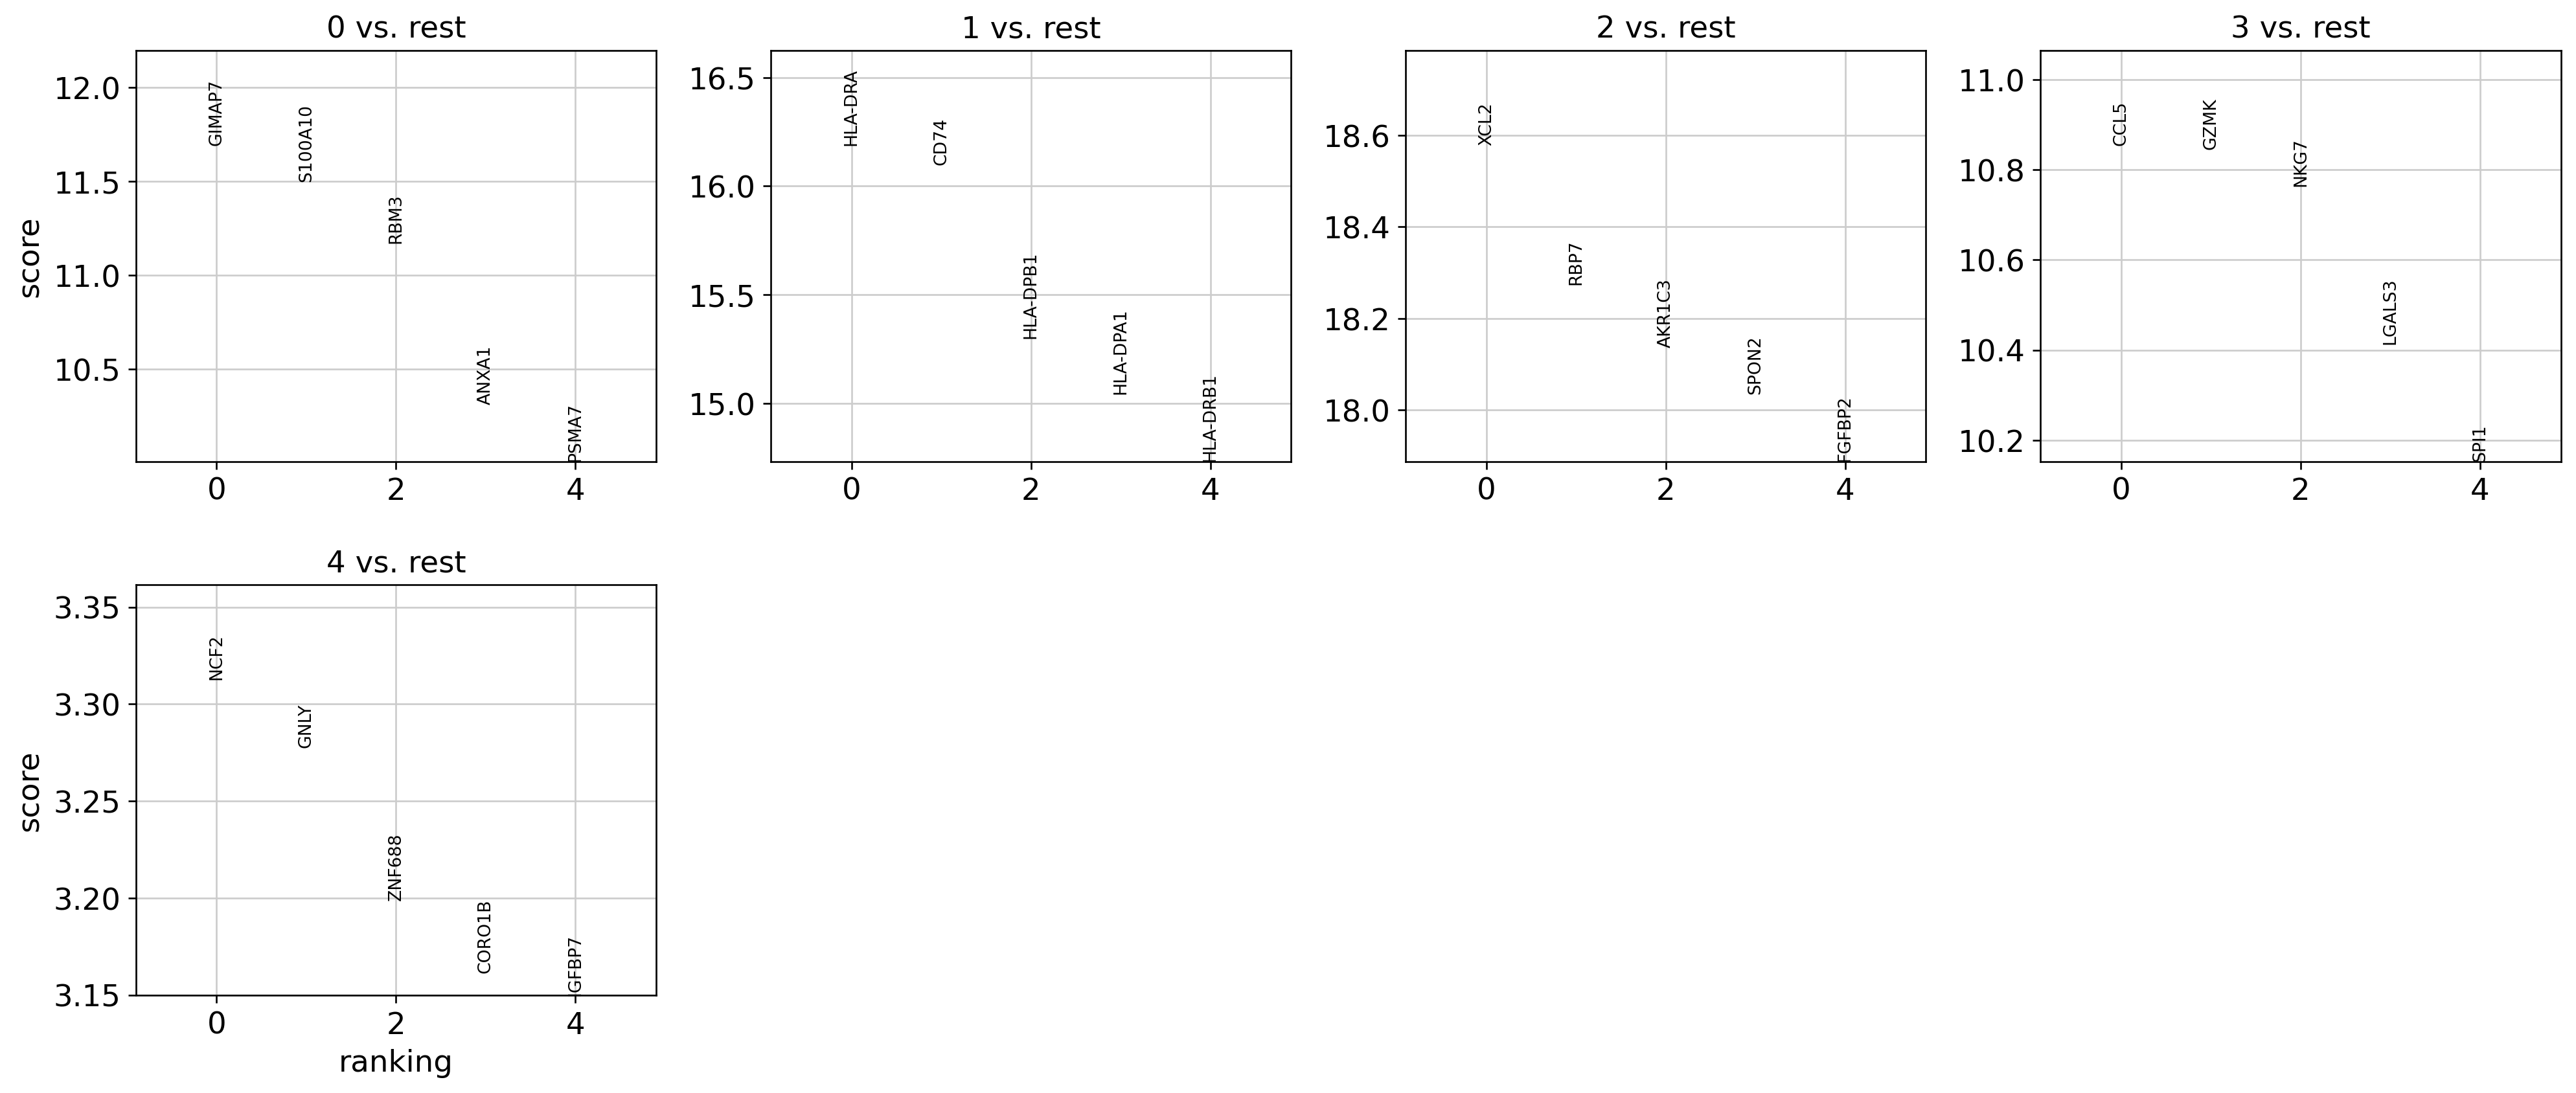

OSError: Cannot save file into a non-existent directory: '../results/tables'

In [17]:
import scanpy as sc
import pandas as pd

# cria cópia limpa e normalizada sem escalar
adata_raw = adata.copy()
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
adata_raw.raw = adata_raw

# mantém os clusters existentes
adata_raw.obs["leiden_scvi"] = adata.obs["leiden_scvi"].values

# análise diferencial
sc.tl.rank_genes_groups(adata_raw, groupby="leiden_scvi", method="wilcoxon", use_raw=True)
sc.pl.rank_genes_groups(adata_raw, n_genes=5, sharey=False)

# exporta resultados
de = sc.get.rank_genes_groups_df(adata_raw, group=None)
de.to_csv("../results/tables/pbmc3k_rank_genes_leiden_scvi.csv", index=False)
print("Salvo em ../results/tables/pbmc3k_rank_genes_leiden_scvi.csv")


ranking genes
    finished: added to `.uns['de_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/leomoraisf/micromamba/envs/sc-omics/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value

Salvo: ../results/tables/pbmc3k_rank_genes_leiden_scvi_wilcoxon.csv


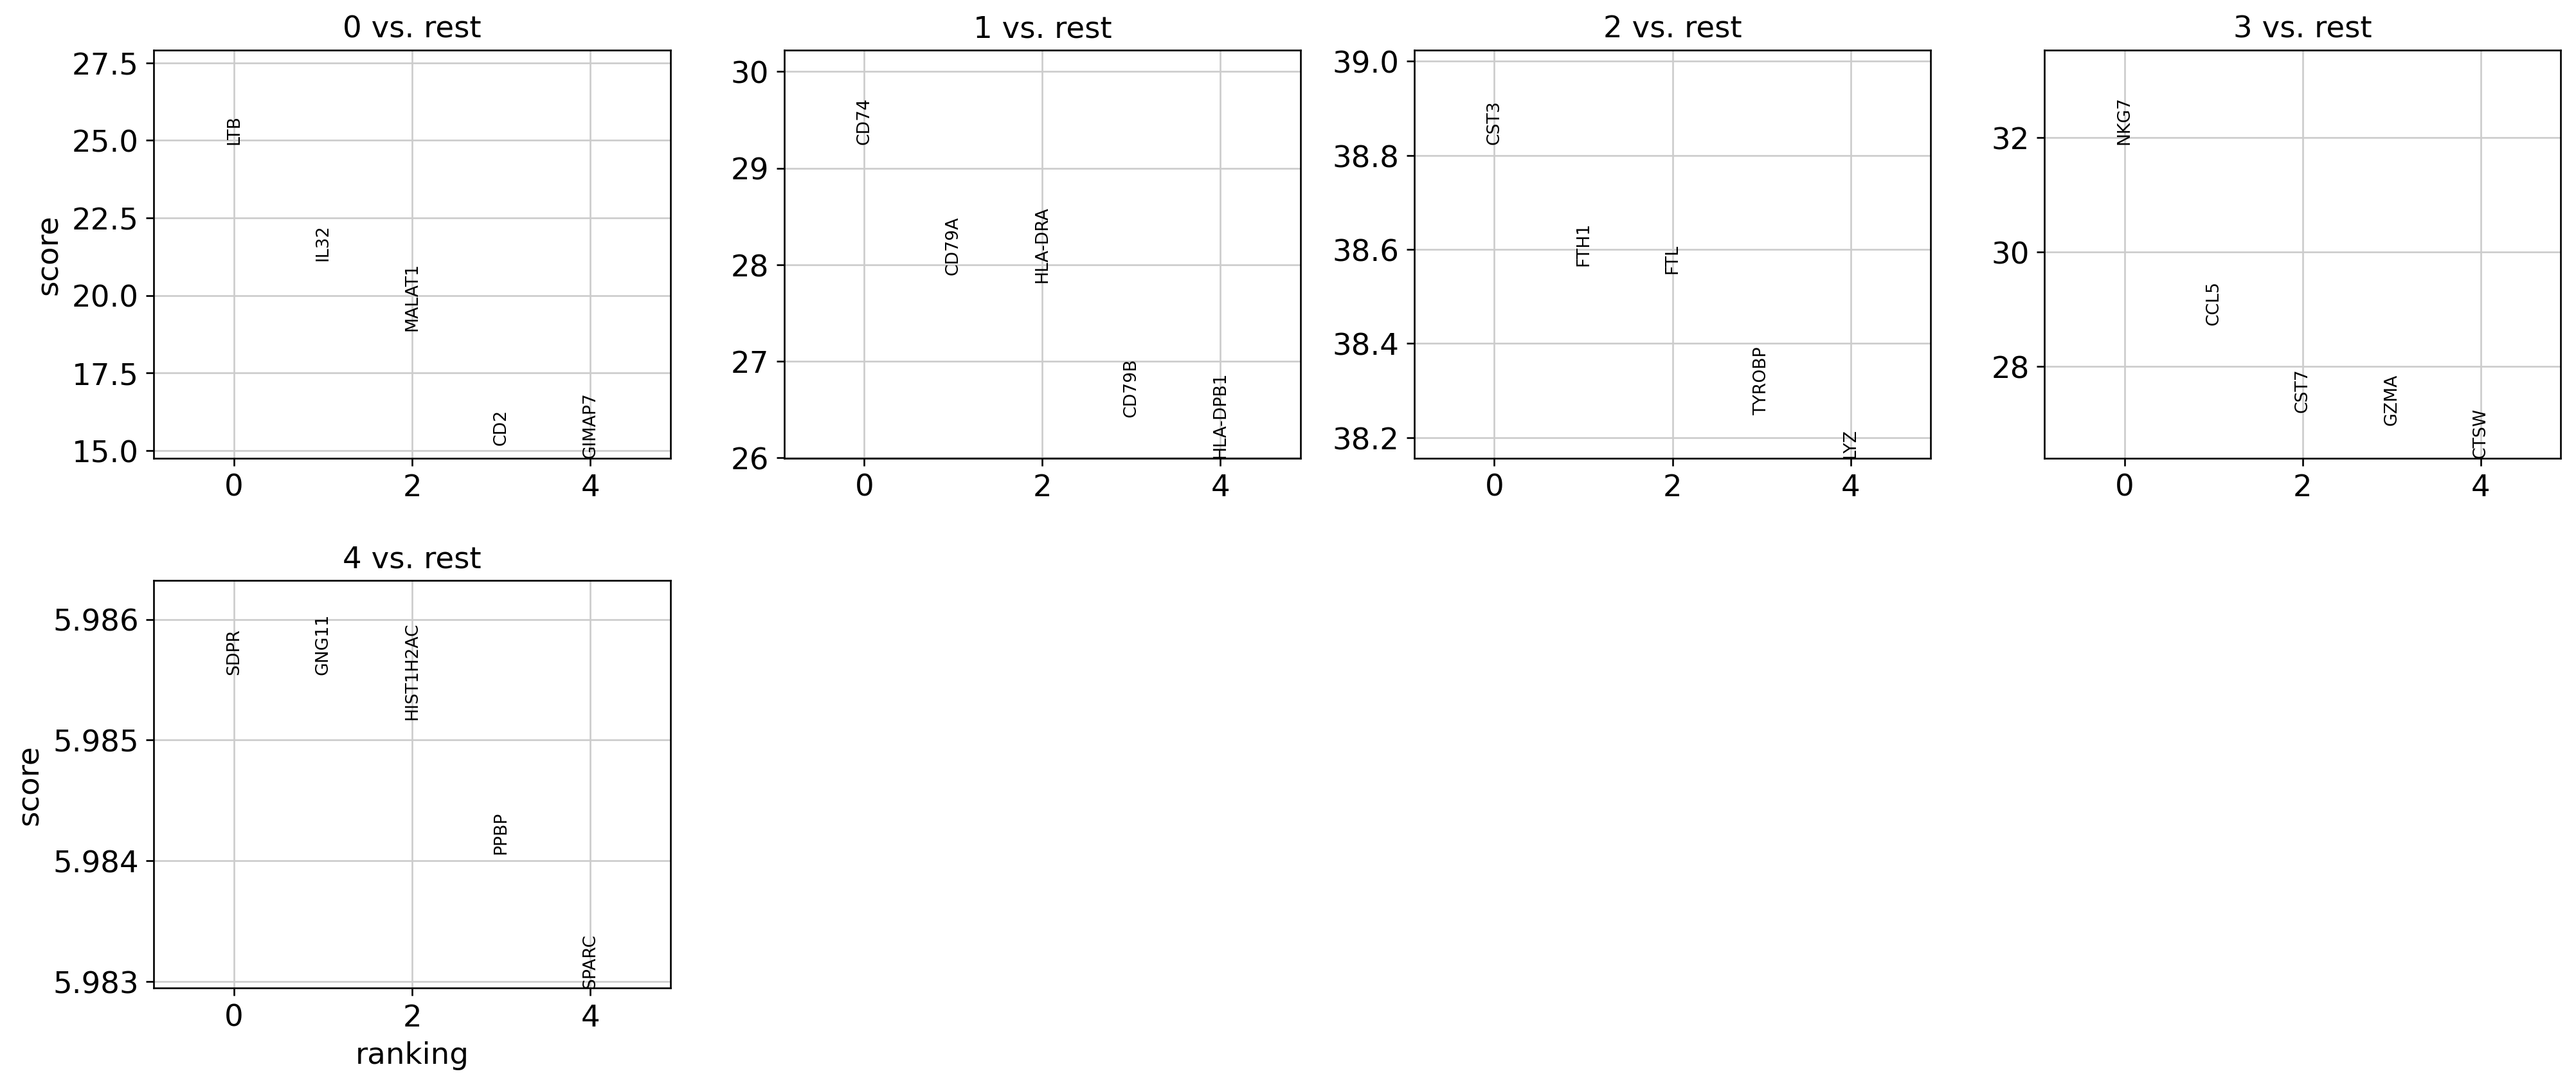

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path

out_dir = Path("../results/tables")
out_dir.mkdir(parents=True, exist_ok=True)

# (1) Evite relogar: use o X atual como está
adata_de = adata.copy()
adata_de.obs["leiden_scvi"] = adata.obs["leiden_scvi"].astype("category")

# (2) Filtre genes totalmente zero para evitar log2FC NaN
# (mantém genes com alguma expressão em pelo menos 5 células, ajuste se quiser)
min_cells = 5
mask = (adata_de.X > 0).sum(axis=0).A1 if hasattr(adata_de.X, "A1") else (adata_de.X > 0).sum(axis=0)
adata_de = adata_de[:, mask >= min_cells].copy()

# (3) DE com Wilcoxon e sem usar .raw (evita o segundo log)
sc.tl.rank_genes_groups(
    adata_de,
    groupby="leiden_scvi",
    method="wilcoxon",
    use_raw=False,
    pts=True,              # percent-genes expressed por grupo
    key_added="de_wilcoxon"
)

# (4) Puxar dataframe e limpar NaNs de log2FC (opcional: remover linhas com NaN)
df = sc.get.rank_genes_groups_df(adata_de, group=None, key="de_wilcoxon")
df = df.dropna(subset=["logfoldchanges"]).reset_index(drop=True)

# (5) Ordenar e salvar
df = df.sort_values(["group", "pvals_adj", "logfoldchanges"], ascending=[True, True, False])
df.to_csv(out_dir / "pbmc3k_rank_genes_leiden_scvi_wilcoxon.csv", index=False)
print("Salvo:", out_dir / "pbmc3k_rank_genes_leiden_scvi_wilcoxon.csv")

# (6) Plot rápido dos top genes por cluster
sc.pl.rank_genes_groups(adata_de, key="de_wilcoxon", n_genes=5, sharey=False)


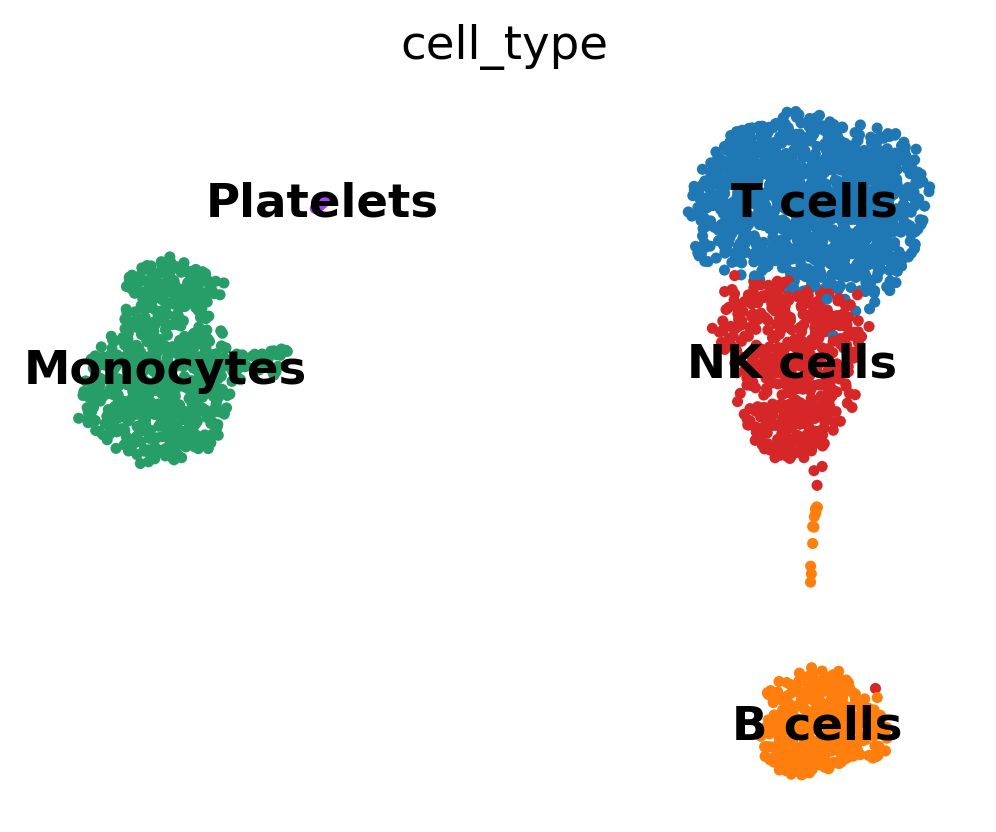

✅ Arquivo salvo: ../results/adata/pbmc3k_annotated.h5ad


In [19]:
import pandas as pd
import scanpy as sc

# Dicionário de anotação
cluster_labels = {
    "0": "T cells",
    "1": "B cells",
    "2": "Monocytes",
    "3": "NK cells",
    "4": "Platelets"
}

# Adiciona ao objeto
adata.obs["cell_type"] = adata.obs["leiden_scvi"].map(cluster_labels)

# UMAP colorido por tipo celular
sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False)

# Salva
adata.write("../results/adata/pbmc3k_annotated.h5ad", compression="gzip")
print("✅ Arquivo salvo: ../results/adata/pbmc3k_annotated.h5ad")


In [20]:
adata.obs[["leiden_scvi", "cell_type"]].to_csv("../results/tables/pbmc3k_celltype_annotations.csv")


In [21]:
import scanpy as sc
from pathlib import Path

adata = sc.read("../results/adata/pbmc3k_annotated.h5ad")
print(adata)


AnnData object with n_obs × n_vars = 2700 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'cell_type'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_scvi', 'leiden_scvi_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


In [22]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    key="de_wilcoxon",
    groups=adata.obs["leiden_scvi"].cat.categories,
    n_genes=5,
    show_gene_labels=True,
    cmap="RdBu_r",
    dendrogram=False,
    swap_axes=True
)


KeyError: 'de_wilcoxon'

In [23]:
# 1) Veja o que existe no .uns
[k for k in adata.uns.keys() if 'rank' in k or 'de' in k or 'wilcoxon' in k]


['leiden_scvi', 'leiden_scvi_colors', 'rank_genes_groups']

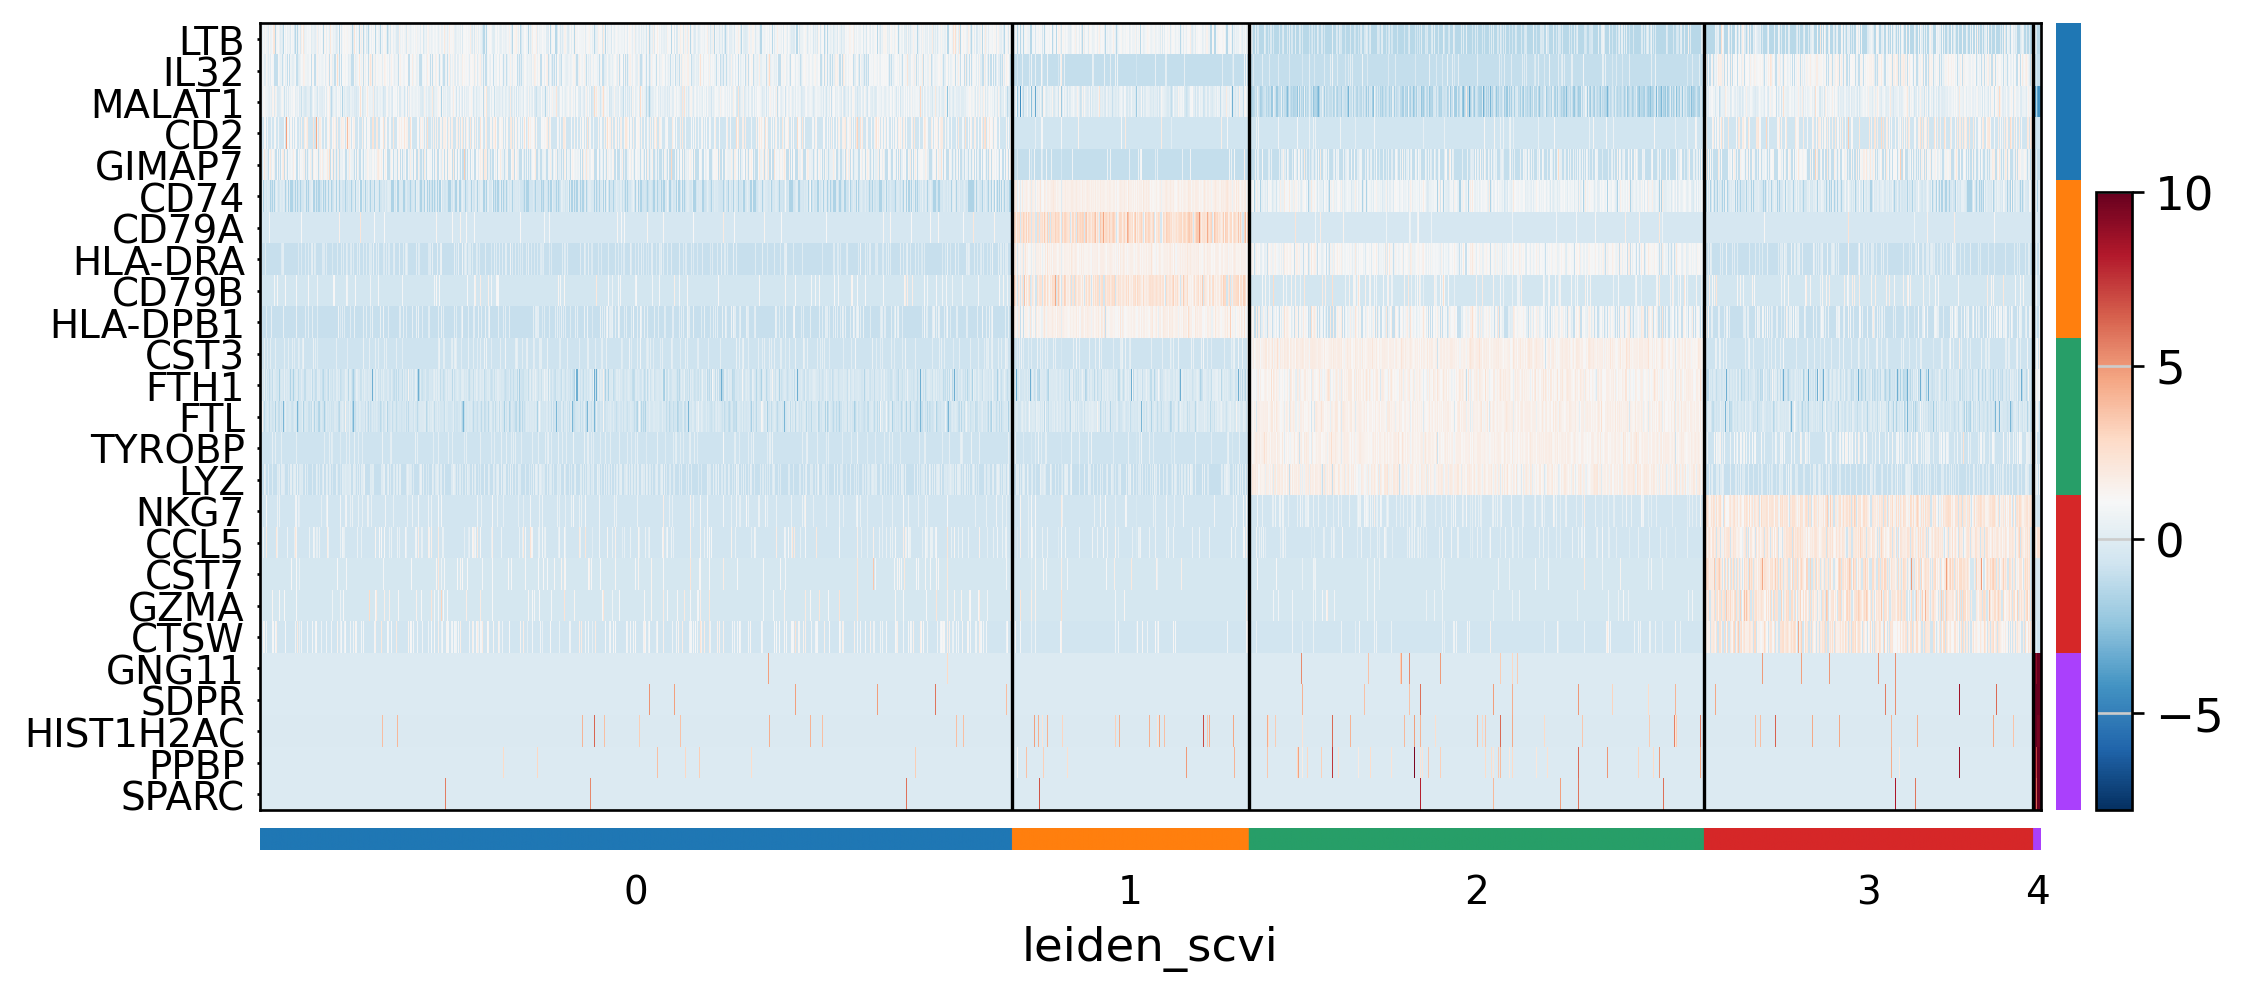

In [24]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    key="rank_genes_groups",  # nome correto
    groups=adata.obs["leiden_scvi"].cat.categories,
    n_genes=5,
    show_gene_labels=True,
    cmap="RdBu_r",
    dendrogram=False,
    swap_axes=True
)


KeyError: "Could not find keys ['CD19', 'CD3D'] in columns of `adata.obs` or in adata.var_names."

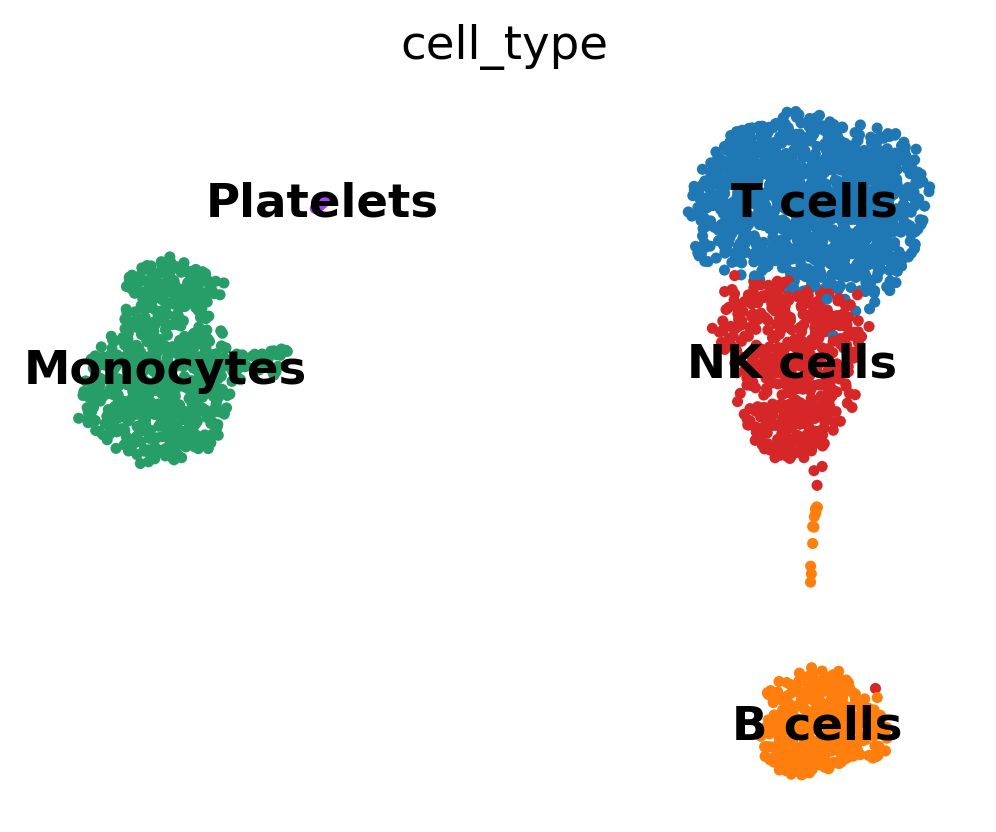

In [25]:
from pathlib import Path
import scanpy as sc
import matplotlib.pyplot as plt

# Cria pasta se ainda não existir
fig_dir = Path("../results/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

# 1️⃣ UMAP colorido por tipo celular
sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False, show=False)
plt.savefig(fig_dir / "pbmc3k_umap_celltype.png", dpi=300, bbox_inches="tight")

# 2️⃣ Dotplot com genes marcadores
marker_genes = {
    "T cells": ["CD3D", "IL32", "LTB"],
    "B cells": ["MS4A1", "CD19", "CD79A"],
    "Monocytes": ["LYZ", "CST3", "TYROBP"],
    "NK cells": ["NKG7", "GNLY", "GZMA"],
    "Platelets": ["PPBP", "SDPR"]
}
sc.pl.dotplot(adata, marker_genes, groupby="cell_type", standard_scale="var", show=False)
plt.savefig(fig_dir / "pbmc3k_dotplot_markers.png", dpi=300, bbox_inches="tight")

# 3️⃣ Heatmap de DEGs por cluster
sc.pl.rank_genes_groups_heatmap(
    adata, key="rank_genes_groups", n_genes=5,
    show_gene_labels=True, cmap="RdBu_r",
    dendrogram=False, swap_axes=True, show=False
)
plt.savefig(fig_dir / "pbmc3k_heatmap_DEGs.png", dpi=300, bbox_inches="tight")

# 4️⃣ Violin plots para genes chave
sc.pl.violin(adata, keys=["CD3D","MS4A1","LYZ","NKG7","PPBP"], groupby="cell_type", rotation=45, show=False)
plt.savefig(fig_dir / "pbmc3k_violin_genes.png", dpi=300, bbox_inches="tight")

print("✅ Todas as figuras salvas em:", fig_dir.resolve())


❗ Genes ausentes no objeto atual (provável corte por HVG):
  - T cells: CD3D
  - B cells: CD19
✅ Dotplot salvo em: /home/leomoraisf/melanoma_scvi/results/figures/pbmc3k_dotplot_markers.png


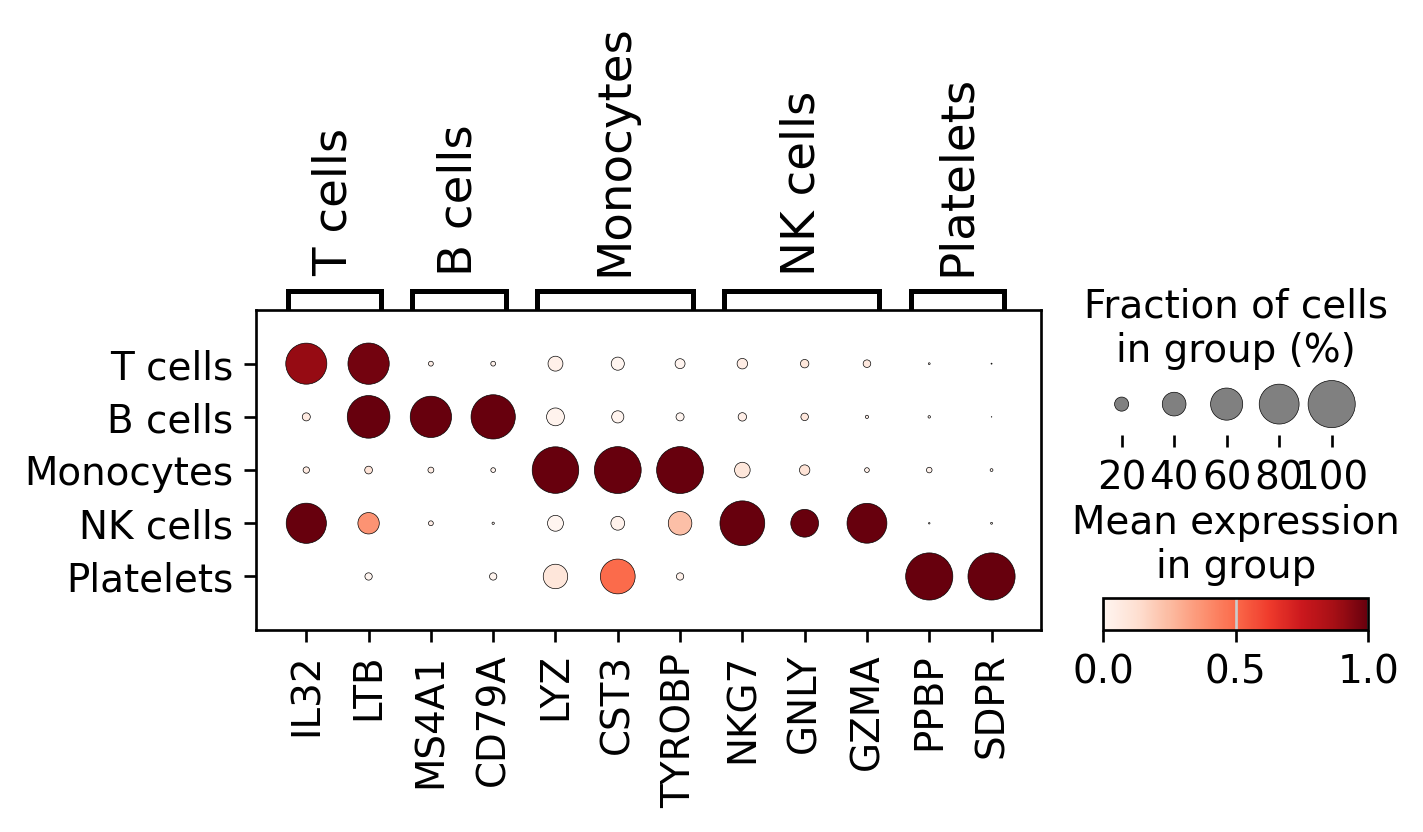

In [26]:
from collections import OrderedDict

# dicionário original
marker_genes = OrderedDict({
    "T cells": ["CD3D", "IL32", "LTB"],
    "B cells": ["MS4A1", "CD19", "CD79A"],
    "Monocytes": ["LYZ", "CST3", "TYROBP"],
    "NK cells": ["NKG7", "GNLY", "GZMA"],
    "Platelets": ["PPBP", "SDPR"],
})

# 1) normaliza nomes (se seu var_names está em upper, mantenha assim)
varnames = set(map(str, adata.var_names))

# 2) filtra para só manter genes presentes
present = OrderedDict()
missing = OrderedDict()
for celltype, genes in marker_genes.items():
    g_present = [g for g in genes if g in varnames]
    g_missing = [g for g in genes if g not in varnames]
    if g_present:
        present[celltype] = g_present
    missing[celltype] = g_missing

print("❗ Genes ausentes no objeto atual (provável corte por HVG):")
for k,v in missing.items():
    if v: print(f"  - {k}: {', '.join(v)}")
    
# 3) plota só com os presentes
import matplotlib.pyplot as plt
from pathlib import Path
fig_dir = Path("../results/figures"); fig_dir.mkdir(parents=True, exist_ok=True)

if any(present.values()):
    sc.pl.dotplot(adata, present, groupby="cell_type", standard_scale="var", show=False)
    plt.savefig(fig_dir / "pbmc3k_dotplot_markers.png", dpi=300, bbox_inches="tight")
    print("✅ Dotplot salvo em:", (fig_dir / "pbmc3k_dotplot_markers.png").resolve())
else:
    print("Nenhum dos marcadores está nas 2000 HVGs atuais.")


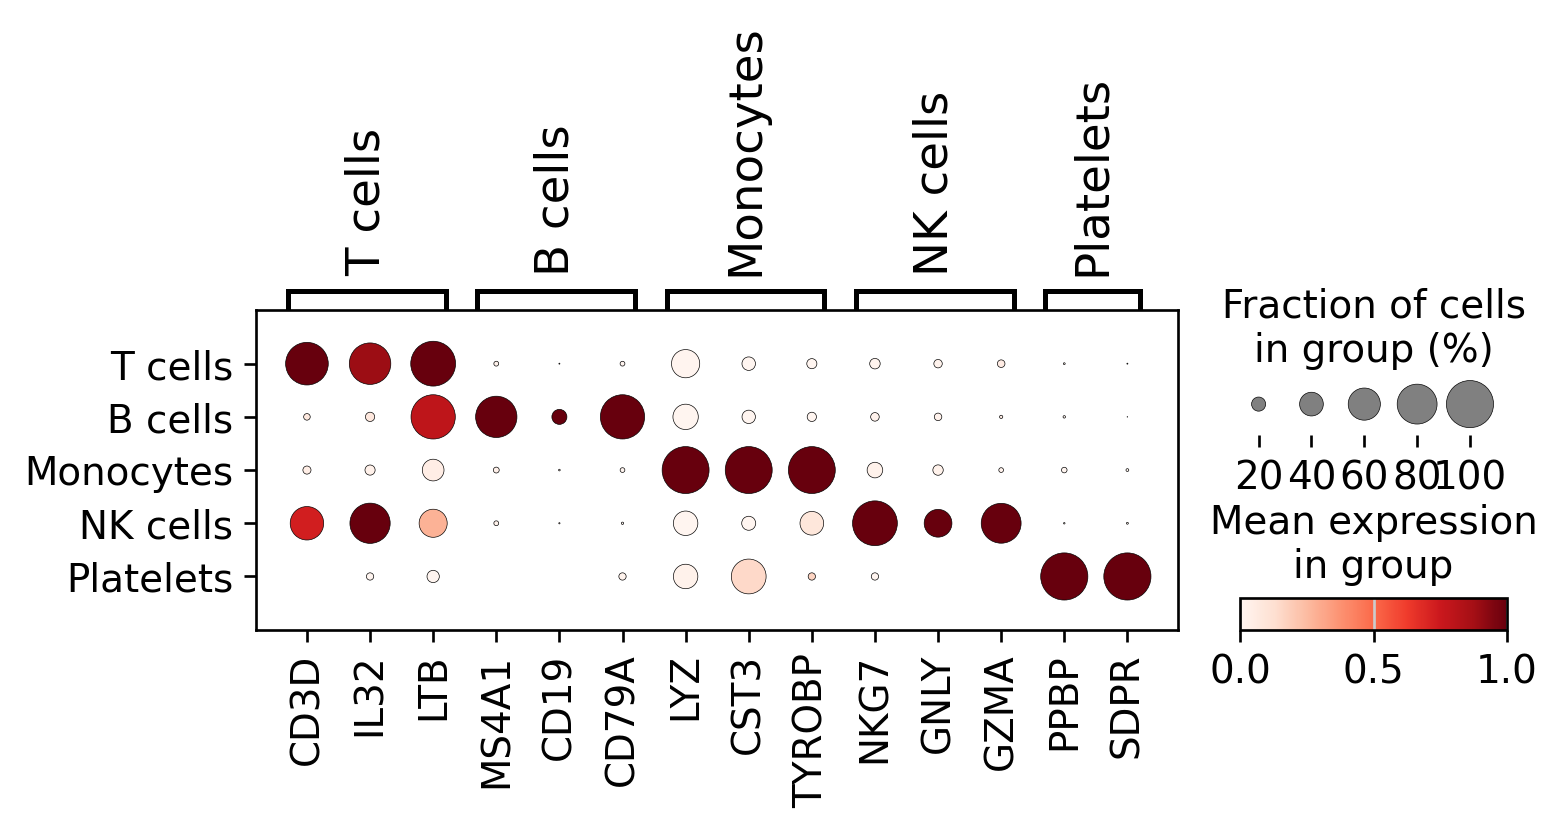

In [27]:
# cria um adata_full só para visualização (sem mexer no seu 'adata' treinado)
adata_full = sc.datasets.pbmc3k()            # ou carregue seu H5AD cru se tiver salvo
adata_full.var_names_make_unique()
adata_full.obs["cell_type"] = adata.obs["cell_type"].reindex(adata_full.obs_names, fill_value="unknown")

# Dotplot agora usando todos os genes (sem HVG), quando disponíveis
sc.pl.dotplot(adata_full, marker_genes, groupby="cell_type", standard_scale="var")


In [28]:
# partindo da sua pasta do projeto
cd ~/melanoma_scvi  # (ou a raiz que você preferir)

# pastas canônicas
mkdir -p data/raw data/processed notebooks src scripts results/figures results/tables envs

# git (se ainda não inicializou)
git init

# licença opcional (MIT)
printf 'MIT License\n\nCopyright (c) 2025 Leonardo Ferreira Morais\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction... (abreviar se quiser)\n' > LICENSE


SyntaxError: invalid syntax (2282939534.py, line 2)

In [29]:
from pathlib import Path
import scanpy as sc

root = Path.home() / "melanoma_scvi"
fig_dir = root / "results" / "figures"
tab_dir = root / "results" / "tables"
proc_dir = root / "data" / "processed"
raw_dir = root / "data" / "raw"

fig_dir.mkdir(parents=True, exist_ok=True)
tab_dir.mkdir(parents=True, exist_ok=True)
proc_dir.mkdir(parents=True, exist_ok=True)

# 1) salva objeto processado (com embeddings e anotações)
proc_path = proc_dir / "pbmc3k_scvi_processed.h5ad"
adata.write(proc_path)
print("✔ Salvo:", proc_path)

# 2) exporta UMAP com clusters
sc.pl.umap(adata, color=["leiden_scvi"], legend_loc="on data", frameon=False, show=False)
umap_png = fig_dir / "pbmc3k_umap_leiden_scvi.png"
import matplotlib.pyplot as plt
plt.savefig(umap_png, dpi=300, bbox_inches="tight"); plt.close()
print("✔ Figura:", umap_png)

# 3) ranking de genes (se ainda não tiver salvo)
if "rank_genes_groups" in adata.uns:
    import pandas as pd, numpy as np
    rg = adata.uns["rank_genes_groups"]
    groups = rg["names"].dtype.names
    rows = []
    for g in groups:
        for i,gene in enumerate(rg["names"][g]):
            rows.append({
                "group": g,
                "rank": i+1,
                "gene": gene,
                "logfoldchange": rg["logfoldchanges"][g][i] if "logfoldchanges" in rg else np.nan,
                "score": rg["scores"][g][i] if "scores" in rg else np.nan,
                "pval": rg["pvals"][g][i] if "pvals" in rg else np.nan,
                "pval_adj": rg["pvals_adj"][g][i] if "pvals_adj" in rg else np.nan
            })
    df = pd.DataFrame(rows)
    rnk_csv = tab_dir / "pbmc3k_rank_genes_leiden_scvi.csv"
    df.to_csv(rnk_csv, index=False)
    print("✔ Tabela:", rnk_csv)

# 4) dotplot de marcadores
marker_genes = {
    "T cells": ["CD3D","IL32","LTB"],
    "B cells": ["MS4A1","CD79A","CD79B"],
    "Monocytes": ["LYZ","CST3","TYROBP"],
    "NK cells": ["NKG7","GNLY","GZMA"],
    "Platelets": ["PPBP","SDPR"]
}
sc.pl.dotplot(adata, marker_genes, groupby="cell_type", standard_scale="var", show=False)
dot_png = fig_dir / "pbmc3k_dotplot_markers.png"
plt.savefig(dot_png, dpi=300, bbox_inches="tight"); plt.close()
print("✔ Figura:", dot_png)


✔ Salvo: /home/leomoraisf/melanoma_scvi/data/processed/pbmc3k_scvi_processed.h5ad
✔ Figura: /home/leomoraisf/melanoma_scvi/results/figures/pbmc3k_umap_leiden_scvi.png
✔ Tabela: /home/leomoraisf/melanoma_scvi/results/tables/pbmc3k_rank_genes_leiden_scvi.csv


KeyError: "Could not find keys ['CD3D'] in columns of `adata.obs` or in adata.var_names."

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt

# baixa o bruto e alinha as células à sua análise atual
raw = sc.datasets.pbmc3k()
raw = raw[adata.obs_names].copy()          # mesma ordem de células
raw.obs = adata.obs.copy()                 # copia anotações atuais

# coloca o bruto em .raw do seu objeto atual
adata.raw = raw

# agora pode usar gene set completo no dotplot
marker_genes = {
    "T cells": ["CD3D","IL32","LTB"],
    "B cells":  ["MS4A1","CD79A","CD79B"],
    "Monocytes":["LYZ","CST3","TYROBP"],
    "NK cells": ["NKG7","GNLY","GZMA"],
    "Platelets":["PPBP","SDPR"],
}

sc.pl.dotplot(adata, marker_genes, groupby="cell_type",
              use_raw=True, standard_scale="var", show=False)
plt.savefig("../results/figures/pbmc3k_dotplot_markers.png", dpi=300, bbox_inches="tight"); plt.close()
print("✔ Dotplot salvo")


✔ Dotplot salvo
